In [2]:
import gala
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import astropy.coordinates as coord
from gala.dynamics import mockstream as ms
from gala.dynamics.nbody import DirectNBody
from gala.units import galactic, solarsystem, dimensionless, UnitSystem
import pylab as plt
from importlib import reload
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd

# Some lines added by HH ------------------------------------------------------
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import math
pi = math.pi
%config IPCompleter.use_jedi = False 
%config InlineBackend.figure_format = 'retina'

import seaborn as sea
# not really necessary
sea.set(font_scale=3,palette=sea.color_palette('colorblind'), 
        rc={'axes.facecolor':'white'},font='Helvetica',color_codes=False)
sea.set_style(style="ticks",rc={"xtick.direction": "in","ytick.direction": "in",
                                "xtick.minor.size": 4, "ytick.minor.size": 4})

#------------------------------------------------------------------------------

In [3]:
import ipyvolume as ipv

In [7]:
ic_Sag = pd.read_csv('./current_pv-sgr.dat', delim_whitespace=True)

# NB:

In [8]:
# Check these values!!
vx_sun,vy_sun, vz_sun = 11.1, 252.24, 7.25
x_sun, y_sun, z_sun = -8.122, 0., 0.014

# IC of Sag (and LMC)

In [9]:
# values from Laporte+2018; https://ui.adsabs.harvard.edu/abs/2018MNRAS.473.1218L/abstract
# pot_LMC = gp.PlummerPotential(m=10.7e10*u.Msun,b=13.5*u.kpc,units=galactic)

# Mass from from Vasiliev+2019 https://arxiv.org/abs/2009.10726
pot_LMC = gp.PlummerPotential(m=1.3e11*u.Msun,b=13.5*u.kpc,units=galactic)

pos_LMC = (np.array([7.1,-41.0,-27.8]) + np.array([x_sun,y_sun,z_sun]))*u.kpc
vel_LMC = (np.array([-68.6,-468.4,201.0] + np.array([vx_sun,vy_sun,vz_sun])))*u.km/u.s

w_LMC = gd.PhaseSpacePosition(pos = pos_LMC, vel = vel_LMC)


# values from Vasiliev+2019 
pot_Sag = gp.PlummerPotential(m=4e8*u.Msun,b=1.5*u.kpc,units=galactic)

pos_Sag = (ic_Sag[['X','Y','Z']].values[0] + np.array([x_sun,y_sun,z_sun]))*u.kpc
vel_Sag = (ic_Sag[['U','V','W']].values[0] + np.array([vx_sun,vy_sun,vz_sun]))*u.km/u.s

w_Sag = gd.PhaseSpacePosition(pos = pos_Sag, vel = vel_Sag)


In [10]:
# Potential of host

MWpot = gp.MilkyWayPotential()

## Inserting also Antlia 2

In [12]:
import vaex

In [13]:
df = vaex.open('/home/koppelman/data/datasets/catalogues/NearbyGalaxies_Jan2021_PUBLIC.fits')

In [26]:
ind = (df.GalaxyName == b'Antlia2         ').values.argmax()
df.take([ind])

#,GalaxyName,RA,Dec,EB_V,dmod,dmod_,dmod__1,vh,vh_,vh__1,Vmag,Vmag_,Vmag__1,PA,PA_,PA__1,e_1_b_a,e_,e__1,muVo,muVo_,muVo__1,rh,rh_,rh__1,sigma_s,sigma_s_,sigma_s__1,vrot_s,vrot_s_,vrot_s__1,MHI,sigma_g,sigma_g_,sigma_g__1,vrot_g,vrot_g_,vrot_g__1,_Fe_H_,feh_,feh__1,F,pmra,epmra_,epmra__1,pmdec,epmdec_,epmdec__1,References
0,b'Antlia2 ',b'9:35:32.8 ',b'-36:46:2.0 ',0.15,20.6,0.11,0.11,290.7,0.5,0.5,11.57,0.15,0.15,156,6,6,0.38,0.08,0.08,30.22,0.65,0.65,76.2,7.2,7.2,5.71,1.08,1.08,999,999,999,999,999,999,999,999,999,999,-1.36,0.04,0.04,2,-0.09,0.01,0.01,0.12,0.01,0.01,"""b'(236)(266)(267) ..."


In [44]:
# Torrealba+2019


d = dict(ra = [143.8868],    # deg
         dec = [-36.7673],   # deg
         l = [264.8955],     # deg
         b = [11.2479],      # deg 
         radial_velocity = [290.7],  # km/s
         pmra = [-0.095], # mas/yr
         pmdec = [0.058], # mas/yr
         distance = [132]) # +=6 kpc

In [46]:
df = vaex.from_arrays(**d) 

In [47]:
df.add_virtual_columns_celestial('ra','dec','l','b',_matrix='eq2gal')
df.add_virtual_columns_spherical_to_cartesian('l', 'b', 'distance')
df.add_virtual_columns_proper_motion_eq2gal('ra', 'dec', 'pmra', 'pmdec')
df.add_virtual_columns_lbrvr_proper_motion2vcartesian('l', 'b', 'distance', vr='radial_velocity')

#,ra,dec,l,b,radial_velocity,pmra,pmdec,distance,x,y,z,pm_l,pm_b,vx,vy,vz
0,143.887,-36.7673,-95.1045,11.2479,290.7,-0.095,0.058,132,-11.5187,-128.951,25.7472,-0.108956,-0.0227496,-93.524,-280.685,42.74


array([[ -11.51873166, -128.9511641 ,   25.74715707]])

In [67]:
pos_A2 = (df[['x','y','z']].values[0] + np.array([x_sun,y_sun,z_sun]))*u.kpc
vel_A2 = (df[['vx','vy','vz']].values[0] + np.array([vx_sun,vy_sun,vz_sun]))*u.km/u.s

w_A2 = gd.PhaseSpacePosition(pos = pos_LMC, vel = vel_LMC)

In [70]:
w_A2 = gd.PhaseSpacePosition(pos = pos_A2, vel = vel_A2)
particle_pots = [None for i in range(w_A2.x.size)]



# Add LMC
w0 = gd.combine((w_LMC,w_A2))
particle_pots.insert(0,pot_LMC)


# Add Sag's pot
w0 = gd.combine((w_Sag,w0))
particle_pots.insert(0,pot_Sag) # massless Sag to isolate effect of LMC!



In [71]:
%%time
nbody = DirectNBody(w0, particle_pots,external_potential=MWpot)
orbits = nbody.integrate_orbit(n_steps=1000, t1=0, t2=-6*u.Gyr)


CPU times: user 56.7 ms, sys: 2.08 ms, total: 58.8 ms
Wall time: 56.4 ms


In [106]:
fig = ipv.figure(width=1000, heigth=1000)

c = ['red','blue','gold']

for i, orb in enumerate(orbits.data.T):
    ipv.plot(*orb.xyz.value, color=c[i])

ipv.save('Antlia2-LMC-Sag.html')


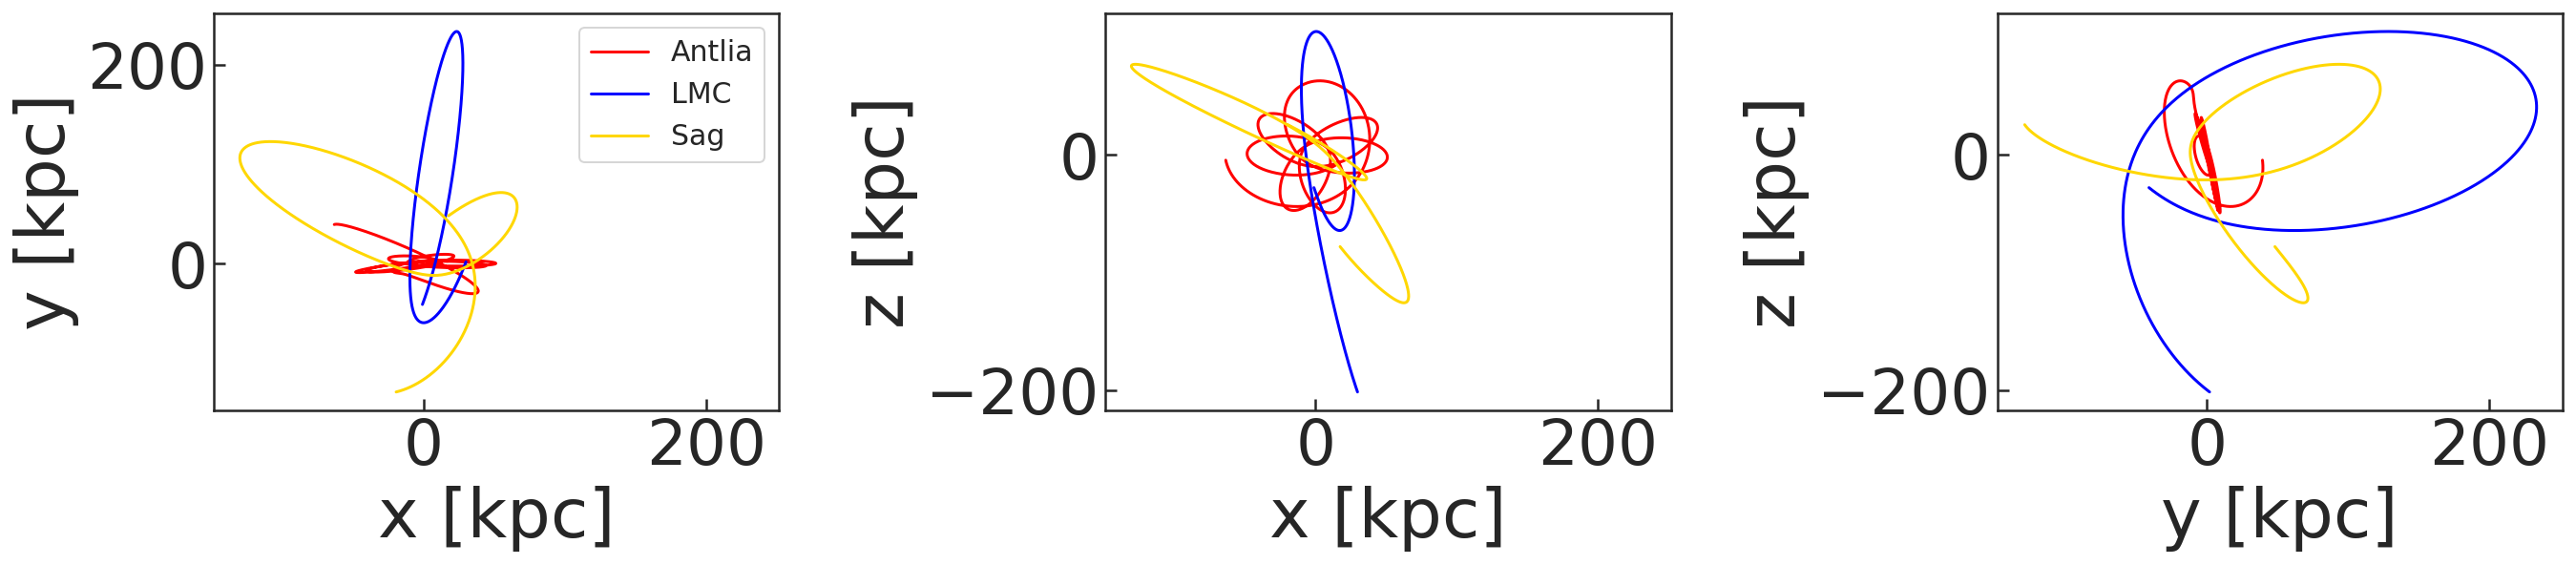

In [124]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5), sharex=True)
l = ['Antlia','LMC','Sag']


for i, orb in enumerate(orbits.data.T):

    axes[0].plot(orb.x,orb.y, c=c[i], label=l[i])
    axes[1].plot(orb.x,orb.z, c=c[i])
    axes[2].plot(orb.y,orb.z, c=c[i])
    
axes[0].legend(fontsize=15)

axes[0].set_xlabel('x [kpc]')
axes[0].set_ylabel('y [kpc]')

axes[1].set_xlabel('x [kpc]')
axes[1].set_ylabel('z [kpc]')

axes[2].set_xlabel('y [kpc]')
axes[2].set_ylabel('z [kpc]')
plt.tight_layout()

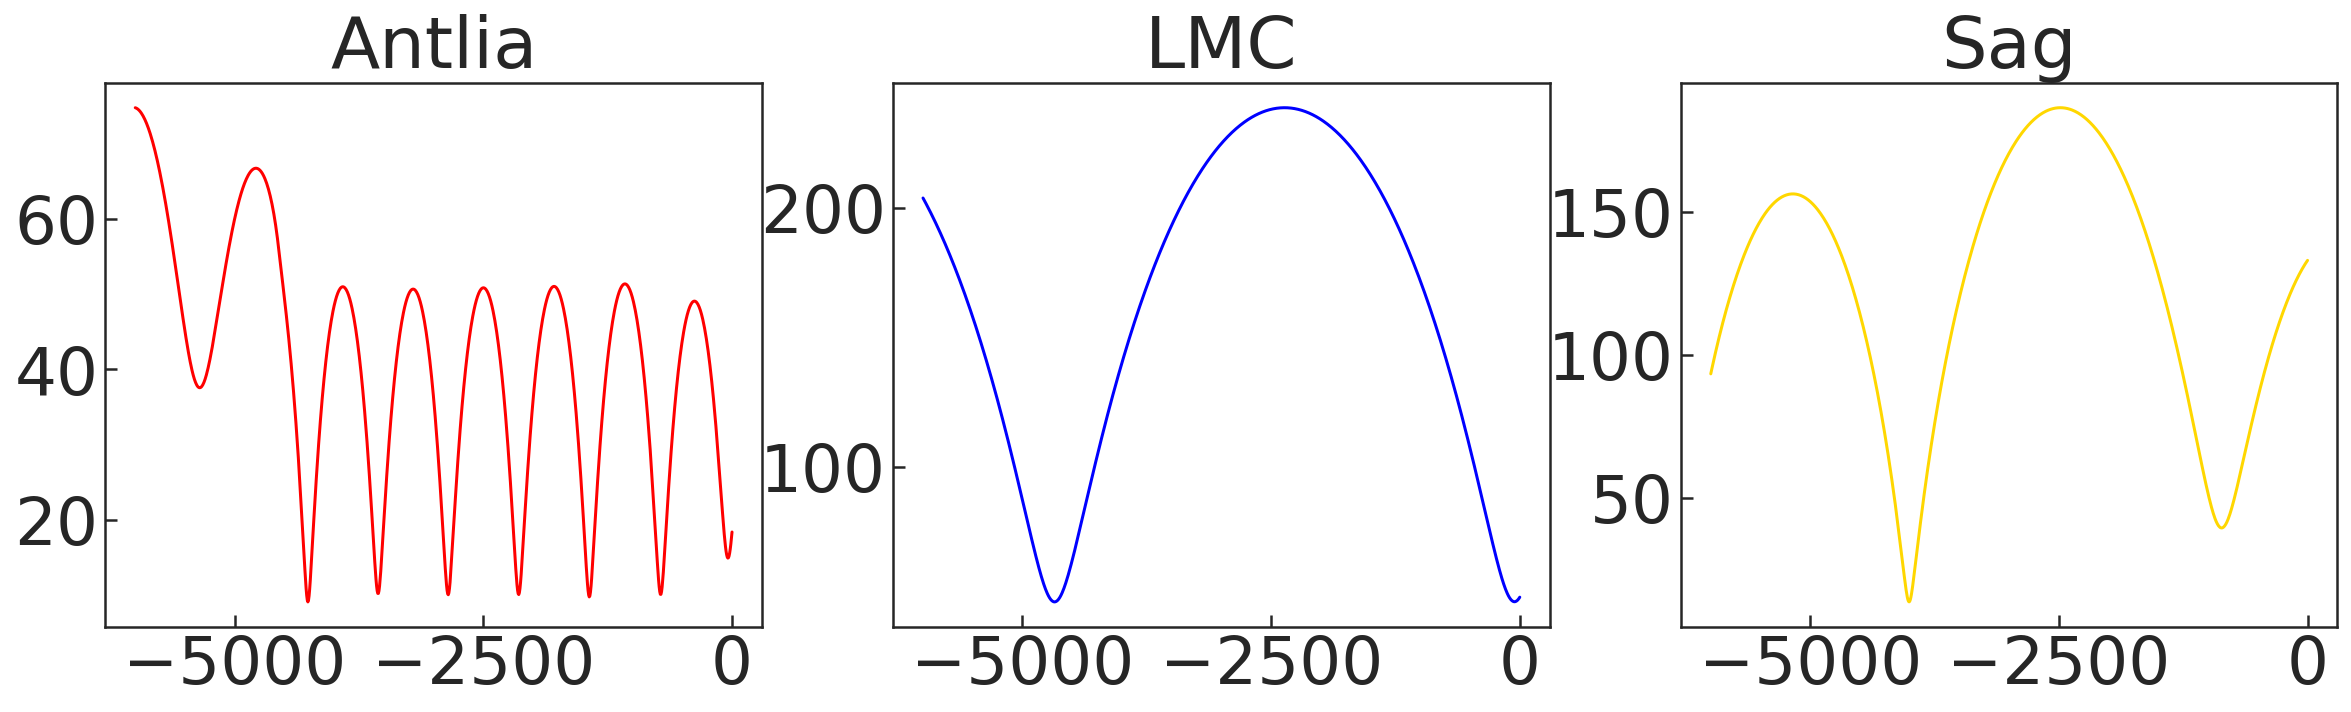

In [117]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5), sharex=True)


for i, orb in enumerate(orbits.data.T):
    r = np.linalg.norm(orb.xyz.value, axis=0)
    axes[i].plot(orbits.t, r, c=c[i])
    axes[i].set_title(l[i])
    
    

Text(0.5, 1.0, 'distance Sag-A2')

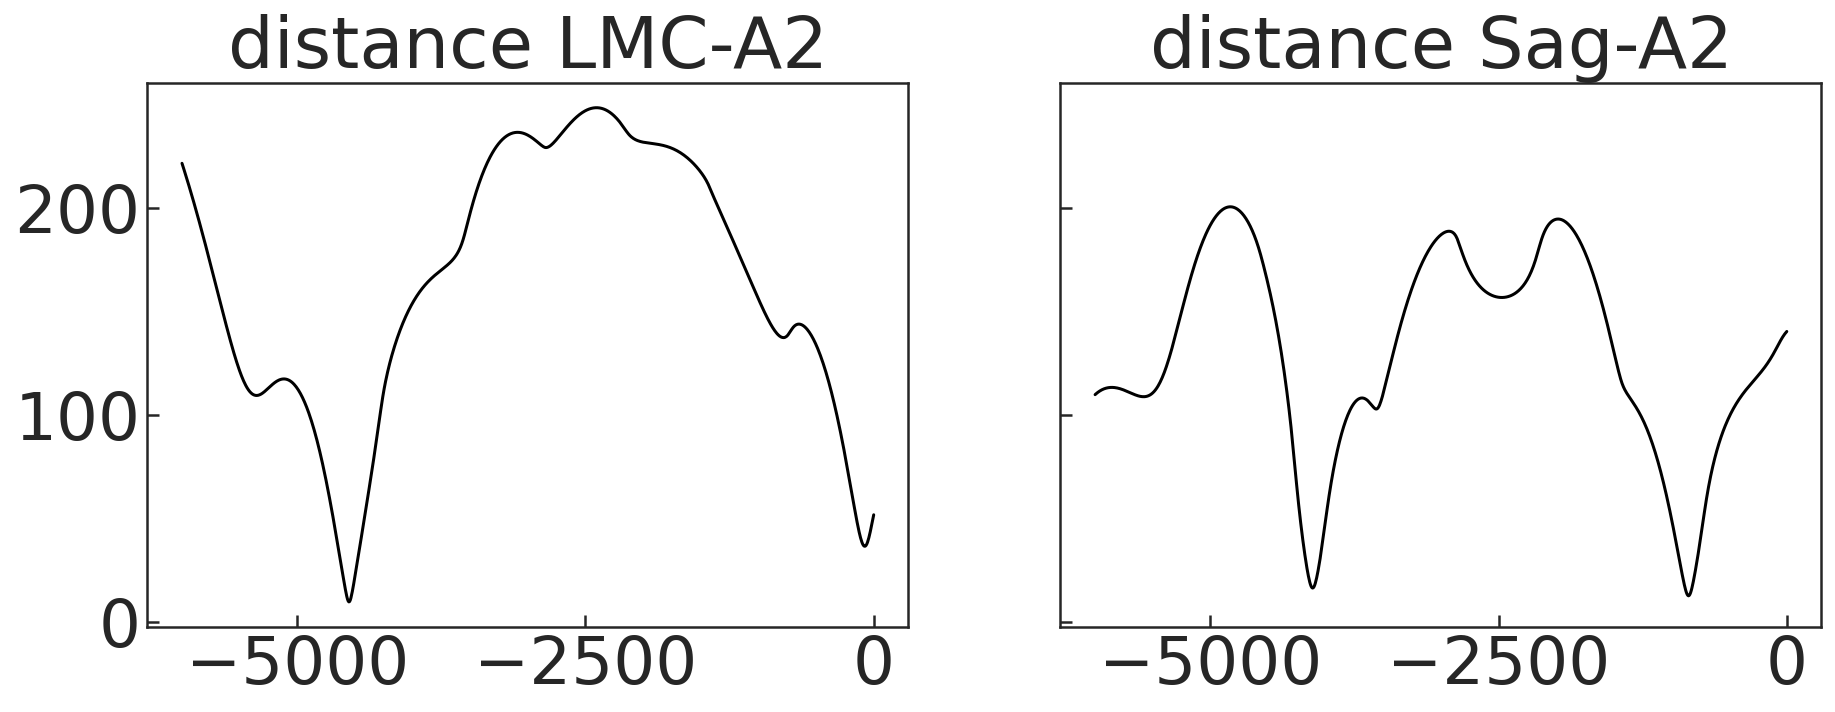

In [130]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharex=True, sharey=True)

A2 = orbits.data.T[0]
LMC = orbits.data.T[1]
Sag = orbits.data.T[2]


dr = np.linalg.norm(A2.xyz.value - LMC.xyz.value, axis=0)
axes[0].plot(orbits.t, dr, c='k')
axes[0].set_title('distance LMC-A2')


dr = np.linalg.norm(A2.xyz.value - Sag.xyz.value, axis=0)
axes[1].plot(orbits.t, dr, c='k')
axes[1].set_title('distance Sag-A2')